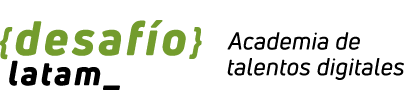

# <font color = 'green'>Identificación de dígitos</font>
Utilizaremos redes neuronales feedforward para realizar detección de dígitos escritos a mano.

## <font color = 'green'>Carga de bibliotecas y datos</color>


In [42]:
!pip install tensorflow
!pip install scikeras
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_openml
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, OneHotEncoder, MinMaxScaler
from sklearn.model_selection import GridSearchCV
from scikeras.wrappers import KerasClassifier

# Las siguientes importaciones de optimizadores y funciones de inicialización de Keras estaban mal escritas
from keras.optimizers import SGD, Adagrad, Adadelta
from keras.models import Sequential
from keras.initializers import HeNormal, GlorotNormal
from keras.regularizers import l1, l2, l1_l2
from keras.constraints import MaxNorm

# Además, es recomendable actualizar la importación de Dropout, ya que puede generar un conflicto de nombres con scikit-learn
from keras.layers import Dropout


In [43]:
X, y = fetch_openml('mnist_784', version=1, return_X_y=True, parser='auto')
X = X.values
y = y.astype(int).values

Veremos algunos ejemplos de las imágenes que hemos cargado

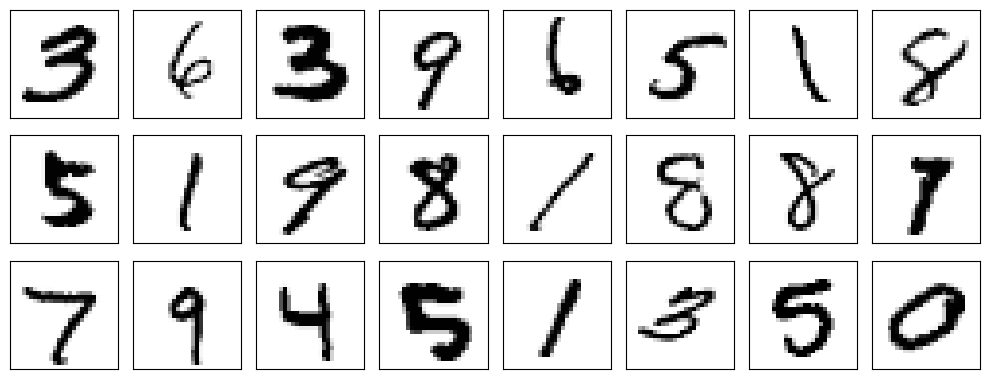

In [44]:
nrows_ = 3
ncols_ = 8
fig, ax = plt.subplots(nrows=nrows_, ncols=ncols_, sharex=True, sharey=True, figsize=(10,4))

for i in range(nrows_):
    for j in range(ncols_):
        idx_rand_img = np.random.randint(0, X.shape[0]-1)
        img = X[idx_rand_img].reshape(28, 28)
        ax[i][j].imshow(img, cmap='Greys')

ax[0][0].set_xticks([])
ax[0][0].set_yticks([])
plt.tight_layout()
plt.show();

## <font color = 'green'>Reescalando los valores</color>

Reescalaremos los valores de los pixeles entre -1 y 1, para simplificar

In [45]:
mmax_scaler_model = MinMaxScaler(feature_range=(-1, 1))
X = mmax_scaler_model.fit_transform(X)

Además, aplicamos OneHotEncoder para target

In [46]:
y_ohe = OneHotEncoder(sparse_output=False).fit_transform(y.reshape(-1, 1))
y_ohe

array([[0., 0., 0., ..., 0., 0., 0.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

## <font color = 'green'>División del conjunto de datos</font>

In [47]:
X_train, X_test, y_train, y_test = train_test_split(X, y_ohe, test_size=.33, random_state=23, stratify=y)

## <font color = 'green'>Arquitectura de la red neuronal</font>

Vamos a crear ahora la red neuronal. Para ello, consideramos:

- 1 Capa oculta con 80 neuronas y función de activación ReLU. Inicializaremos los pesos usando HeNormal.
- Capa de salida con 10 neuronas, con función de activación softmax. La inicialización de pesos se hará con Glorot Normal.

In [48]:
ann1 = Sequential()

# Capa de entrada donde se establece las dimensiones de las observaciones
ann1.add(keras.Input(shape=(X_train.shape[1], )))

# Se define la cantidad de capas ocultas
n_hidden_layers = 1

# Definir la función de activación que se empleará en
# cada capa oculta
activation_fn = 'relu'

# Definir cantidad de neuronas para cada capa oculta
n_neurons = 20


for hl in range(n_hidden_layers):

    ann1.add(
        Dense(
            units=n_neurons,
            use_bias=True,
            activation=activation_fn,
            kernel_initializer=HeNormal(seed=24),
            bias_initializer='zeros'
        )
    )
# agregar dropout

# Capa de salida
ann1.add(
    Dense(
        units=10,
        use_bias=True,
        activation='softmax',
        kernel_initializer=GlorotNormal(seed=23),
        bias_initializer='zeros'
    )
)

ann1.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_2 (Dense)             (None, 20)                15700     
                                                                 
 dense_3 (Dense)             (None, 10)                210       
                                                                 
Total params: 15910 (62.15 KB)
Trainable params: 15910 (62.15 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


###<font color = 'green'>Compilación y entrenamiento</font>
Se define un batch de 100 observaciones  para 20 épocas, se usa un conjunto de validación del 33%. Como métrica de evaluación se emplea accuracy.

In [49]:
EPOCHS = 5
ann1.compile(optimizer=SGD(learning_rate=0.03), loss='categorical_crossentropy', metrics=['accuracy'])
ann1_history = ann1.fit(X_train, y_train, validation_split=.33, epochs=EPOCHS, batch_size=420, verbose=1)

Epoch 1/5
75/75 [==============================] - 2s 22ms/step - loss: 1.4059 - accuracy: 0.5631 - val_loss: 0.7911 - val_accuracy: 0.7900
Epoch 2/5
75/75 [==============================] - 1s 14ms/step - loss: 0.6461 - accuracy: 0.8249 - val_loss: 0.5494 - val_accuracy: 0.8494
Epoch 3/5
75/75 [==============================] - 1s 9ms/step - loss: 0.4992 - accuracy: 0.8598 - val_loss: 0.4626 - val_accuracy: 0.8697
Epoch 4/5
75/75 [==============================] - 1s 8ms/step - loss: 0.4348 - accuracy: 0.8767 - val_loss: 0.4216 - val_accuracy: 0.8801
Epoch 5/5
75/75 [==============================] - 1s 8ms/step - loss: 0.4007 - accuracy: 0.8844 - val_loss: 0.3929 - val_accuracy: 0.8862


###<font color = 'green'>Predicción</font>

In [50]:
yhat = ann1.predict(X_test)
yhat

722/722 [==============================] - 2s 2ms/step


array([[1.9952892e-04, 1.3477364e-02, 4.8735910e-03, ..., 4.0761330e-03,
        6.8669231e-03, 6.9686049e-03],
       [7.5904524e-04, 6.1131623e-06, 4.6262267e-04, ..., 3.6014854e-03,
        2.4467816e-03, 3.3697179e-01],
       [2.1166362e-02, 8.3953790e-05, 4.2536929e-02, ..., 1.0167982e-01,
        1.1464151e-04, 1.0135630e-02],
       ...,
       [7.5204797e-02, 1.1267257e-05, 2.5641182e-07, ..., 3.9965771e-03,
        1.3545237e-02, 6.5475907e-03],
       [4.3152548e-05, 8.8572961e-06, 3.8538128e-05, ..., 1.3989536e-01,
        1.0844918e-03, 8.4714180e-01],
       [2.3056772e-04, 3.9337557e-03, 5.2686053e-04, ..., 2.0074997e-02,
        7.3884998e-04, 1.4434436e-02]], dtype=float32)

### <font color = 'green'>Asignación de clase para la salida del modelo</font>
Para determinar a que neurona quedan clasificadas las observaciones. Se selecciona aquella con mayor probabilidad.

In [51]:
y_test_class = np.apply_along_axis(lambda x: np.argmax(x), 1, y_test)
yhat_class = np.apply_along_axis(lambda x: np.argmax(x), 1, yhat)
y_test_class

array([3, 4, 2, ..., 5, 9, 3])

## <font color = 'green'>Evaluación del entrenamiento</font>

Podemos notar que para números fáciles de confundir el modelo tiene más problemas para detectar correctamente este valor.

In [52]:
print(classification_report(y_test_class, yhat_class))

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      2278
           1       0.89      0.96      0.93      2599
           2       0.88      0.85      0.86      2307
           3       0.84      0.86      0.85      2357
           4       0.92      0.87      0.89      2252
           5       0.85      0.82      0.83      2083
           6       0.93      0.95      0.94      2269
           7       0.90      0.91      0.91      2407
           8       0.89      0.81      0.85      2252
           9       0.83      0.87      0.85      2296

    accuracy                           0.89     23100
   macro avg       0.89      0.89      0.89     23100
weighted avg       0.89      0.89      0.89     23100



### <font color = 'green'>Visualización de las predicciones</font>

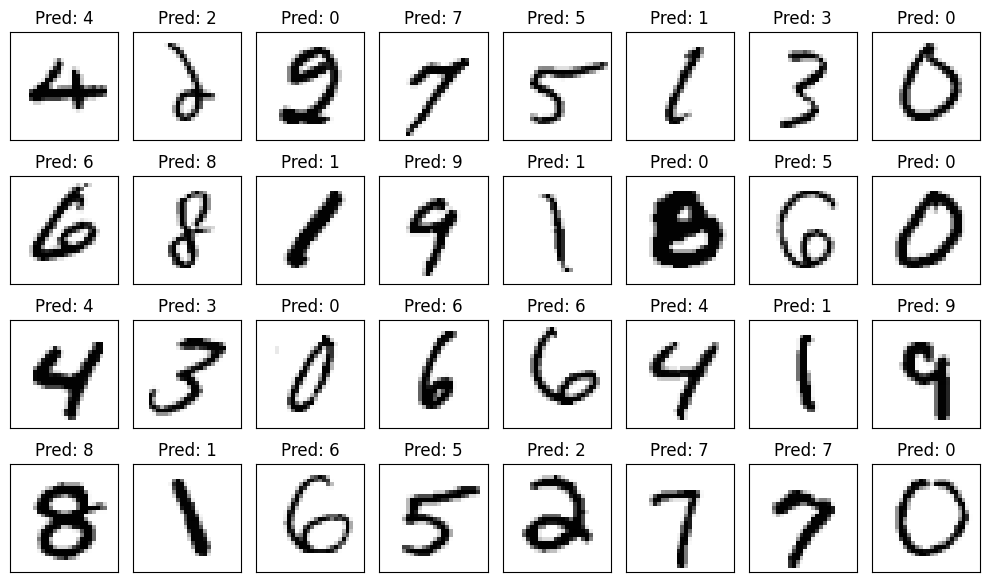

In [53]:
def predictions_viz(X_test, yhat_class, nrows=4, ncols=8, seed=202433):
    fig, ax = plt.subplots(nrows=nrows, ncols=ncols, sharex=True, sharey=True, figsize=(10,6))
    X_test_aux = mmax_scaler_model.inverse_transform(X_test)
    np.random.seed(seed)

    for i in range(nrows):
        for j in range(ncols):
            idx_rand_img = np.random.randint(0, X_test_aux.shape[0]-1)
            img = X_test_aux[idx_rand_img].reshape(28, 28)
            ax[i][j].imshow(img, cmap='Greys')
            ax[i][j].set_title(f'Pred: {yhat_class[idx_rand_img]}')

    ax[0][0].set_xticks([])
    ax[0][0].set_yticks([])
    plt.tight_layout()
    plt.show();

predictions_viz(X_test, yhat_class)

### <font color = 'green'>Visualización de la función de pérdida y métrica en cada época del entrenamiento de la red neuronal</font>


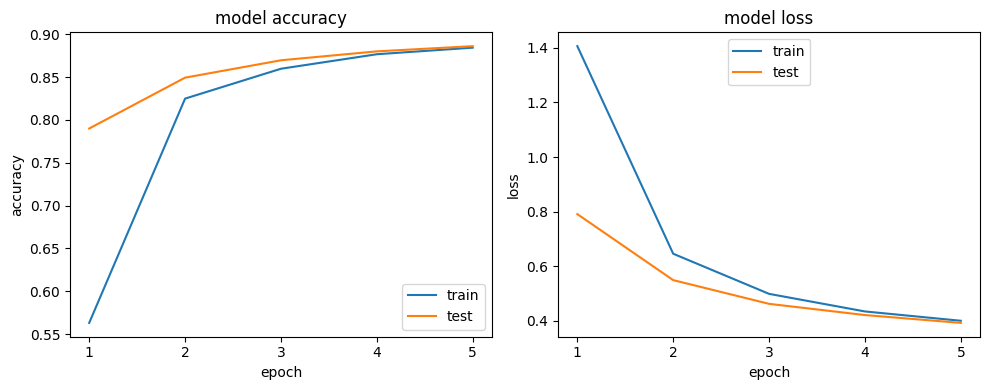

In [54]:
def viz_loss(history):
    epochs_ = len(history['accuracy'])
    fig, ax = plt.subplots(1, 2, figsize=(10, 4))
    ax[0].plot(history['accuracy'])
    ax[0].plot(history['val_accuracy'])
    ax[0].set_xticks(np.arange(epochs_), np.arange(1, epochs_+1))
    ax[0].set_title('model accuracy')
    ax[0].set_ylabel('accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].legend(['train', 'test'], loc='lower right')


    # summarize history for loss
    ax[1].plot(history['loss'])
    ax[1].plot(history['val_loss'])
    ax[1].set_xticks(np.arange(epochs_), np.arange(1, epochs_+1))
    ax[1].set_title('model loss')
    ax[1].set_ylabel('loss')
    ax[1].set_xlabel('epoch')
    ax[1].legend(['train', 'test'], loc='upper center')

    plt.tight_layout()
    plt.show()

viz_loss(ann1_history.history)

### <font color = 'green'>Búsqueda de hiperparámetros con GridSearchCV</font>

Realizaremos ahora la búsqueda de hiperparámetros, incoporando regularizacionesn L1, L2 y Dropout.  Para ello, crearemos primero la arquitectura de la red neuronal

In [58]:
# Se crea una función que tendrá la arquitectura de nuestro
# modelo de red neuronal la cual debe ser retornado.

# meta es un argumento especial de tipo diccionario con
# información de metadata

def create_model(n_neurons=80, activation='relu', dropout_rate=.001, meta={}):

    n_features_in_ = meta["n_features_in_"]
    X_shape_ = meta["X_shape_"]

    # Restricción para garantizar que la norma de cada
    # vector de pesos no exceda de tres.
    constraint = MaxNorm(max_value=3)

    # Arquitectura secuencial
    ann_tmp = Sequential()

    # Capa de entrada
    ann_tmp.add(keras.Input(shape=(n_features_in_, )))

    # Capas ocultas
    ann_tmp.add(
        Dense(
            units=n_neurons,
            use_bias=True,
            activation=activation,
            kernel_initializer=HeNormal(),
            bias_initializer='zeros',
            kernel_regularizer=l2(l2=0.001),
            kernel_constraint=constraint
        )
    )

    ann_tmp.add(
        Dropout(rate=dropout_rate)
    )

    # Capa se salida
    ann_tmp.add(
        Dense(
            units=10,
            use_bias=True,
            activation='softmax',
            kernel_initializer = HeNormal(),
            bias_initializer='zeros',
            kernel_regularizer=l1(l1=0.001),
            kernel_constraint=constraint
        )
    )

    return ann_tmp

Construimos ahora el modelo usando el Wrapper

In [59]:
clf = KerasClassifier(
    create_model,
    loss='binary_crossentropy',
    optimizer='SGD',
    verbose=1,
    metrics=['accuracy'],
    validation_split=.33
)

Ahora, realizamos la búsqueda por grilla

In [60]:
# Espacio en el que se búsca los hiper parámetros óptimos
param_grid = {
    'model__n_neurons': [30, 40],
    'model__activation': ['relu'],
    'batch_size': [300],
    'epochs': [5, 6],
    'optimizer__learning_rate': [0.07],
    'model__dropout_rate': [0.004, 0.005]
}

# GridSearchCV
grid = GridSearchCV(estimator=clf, param_grid=param_grid,
    scoring='accuracy', cv=3, verbose=0, n_jobs=-1)

grid_result = grid.fit(X_train, y_train)

# Mostrar mejores hiper parámetros encontrados
print("\n\nBest: %f using %s" % (grid_result.best_score_, grid_result.best_params_))

/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Epoch 1/6
105/105 [==============================] - 1s 7ms/step - loss: 0.4318 - accuracy: 0.4469 - val_loss: 0.3647 - val_accuracy: 0.6755
Epoch 2/6
105/105 [==============================] - 0s 5ms/step - loss: 0.3367 - accuracy: 0.7367 - val_loss: 0.3123 - val_accuracy: 0.7847
Epoch 3/6
105/105 [==============================] - 1s 5ms/step - loss: 0.2987 - accuracy: 0.8051 - val_loss: 0.2849 - val_accuracy: 0.8276
Epoch 4/6
105/105 [==============================] - 1s 5ms/step - loss: 0.2771 - accuracy: 0.8343 - val_loss: 0.2680 - val_accuracy: 0.8470
Epoch 5/6
105/105 [==============================] - 0s 4ms/step - loss: 0.2632 - accuracy: 0.8465 - val_loss: 0.2563 - val_accuracy: 0.8584
Epoch 6/6
105/105 [==============================] - 1s 5ms/step - loss: 0.2532 - accuracy: 0.8541 - val_loss: 0.2475 - val_accuracy: 0.8625


Best: 0.844286 using {'batch_size': 300, 'epochs': 6, 'model__activation': 'relu', 'model__dropout_rate': 0.004, 'model__n_neurons': 40, 'optimizer__lea

### <font color = 'green'>Predicción y evaluación de rendimiento</font>

In [61]:
yhat_class = grid_result.best_estimator_.predict(X_test)
yhat_class = np.apply_along_axis(lambda x: np.argmax(x), 1, yhat_class)

print(classification_report(y_test_class, yhat_class))

77/77 [==============================] - 0s 2ms/step
              precision    recall  f1-score   support

           0       0.90      0.95      0.93      2278
           1       0.83      0.97      0.89      2599
           2       0.87      0.82      0.84      2307
           3       0.81      0.83      0.82      2357
           4       0.84      0.90      0.87      2252
           5       0.84      0.74      0.79      2083
           6       0.91      0.91      0.91      2269
           7       0.87      0.89      0.88      2407
           8       0.85      0.78      0.81      2252
           9       0.87      0.78      0.82      2296

    accuracy                           0.86     23100
   macro avg       0.86      0.86      0.86     23100
weighted avg       0.86      0.86      0.86     23100



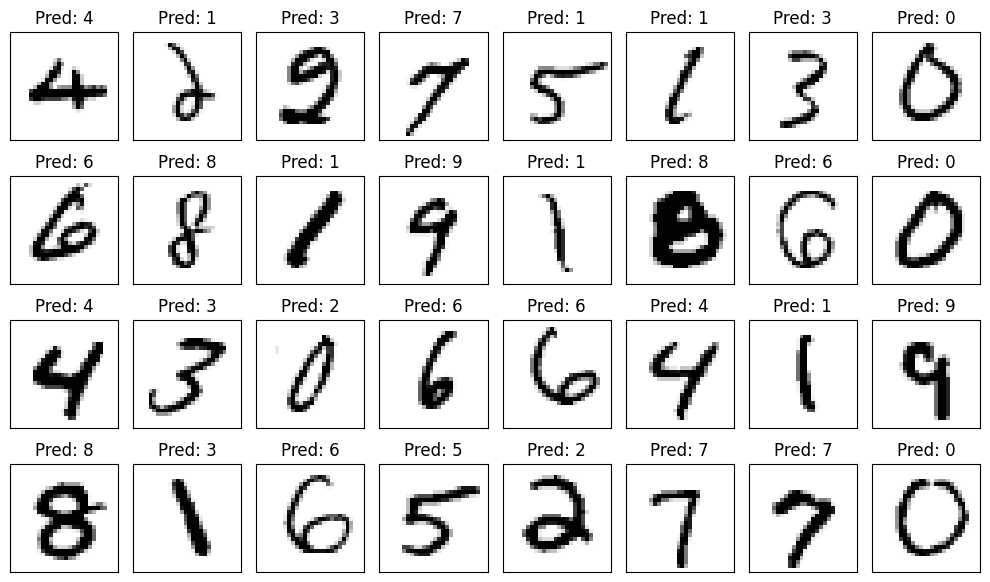

In [62]:
# Visualizamos algunas predicciones realizadas con el modelo
predictions_viz(X_test, yhat_class)

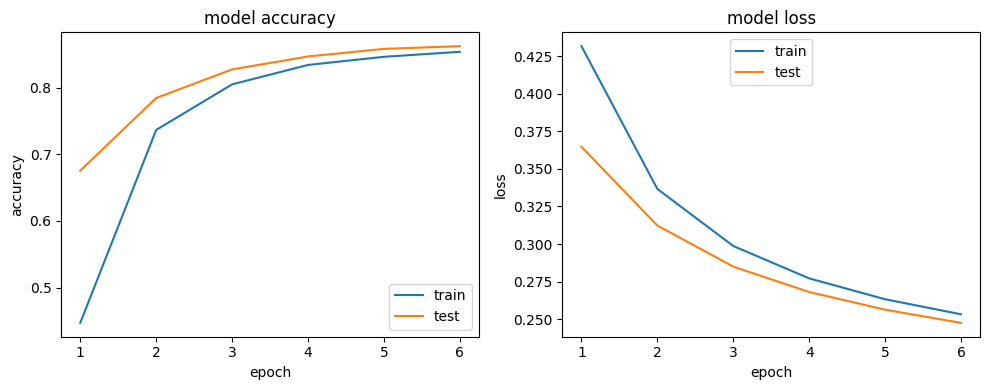

In [63]:
viz_loss(dict(grid_result.best_estimator_.history_))